**Table of contents**<a id='toc0_'></a>    
- 1. [学习笔记概要](#toc1_)    
- 2. [深度神经网络-基础](#toc2_)    
  - 2.1. [神经网络搭建八股-模块化设计](#toc2_1_)    
    - 2.1.1. [基本框架](#toc2_1_1_)    
      - 2.1.1.1. [forward.py](#toc2_1_1_1_)    
    - 2.1.2. [专题-损失函数](#toc2_1_2_)    
      - 2.1.2.1. [均绝对值误差-l1 loss](#toc2_1_2_1_)    
      - 2.1.2.2. [均方误差-l2 loss](#toc2_1_2_2_)    
      - 2.1.2.3. [交叉熵](#toc2_1_2_3_)    
      - 2.1.2.4. [自定义](#toc2_1_2_4_)    
    - 2.1.3. [专题-优化器](#toc2_1_3_)    
      - 2.1.3.1. [梯度下降](#toc2_1_3_1_)    
      - 2.1.3.2. [adagrad](#toc2_1_3_2_)    
      - 2.1.3.3. [RMSProp](#toc2_1_3_3_)    
  - 2.2. [MLP](#toc2_2_)    
  - 2.3. [softmax](#toc2_3_)    
- 3. [卷积神经网络-CNN](#toc3_)    
  - 3.1. [简单CNN](#toc3_1_)    
  - 3.2. [LeNet5](#toc3_2_)    
  - 3.3. [ResNet](#toc3_3_)    
- 4. [循环神经网络-RNN](#toc4_)    
  - 4.1. [简单RNN](#toc4_1_)    
  - 4.2. [LSTM](#toc4_2_)    
  - 4.3. [GRU](#toc4_3_)    
- 5. [注意力机制-Attention](#toc5_)    
  - 5.1. [自注意力](#toc5_1_)    
  - 5.2. [多头注意力](#toc5_2_)    
  - 5.3. [Transformer](#toc5_3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>[学习笔记概要](#toc0_)
```
《动手学习深度学习》：
    Python机器学习-第二版书籍
    动手学深度学习-第二版书籍：http://zh.d2l.ai/chapter_preface/index.html
    动手学深度学习-B站视频：https://space.bilibili.com/1567748478/channel/seriesdetail?sid=358497
    Tensorflow1.3-B站视频：https://www.bilibili.com/video/BV1m7411d7kT/?spm_id_from=333.999.0.0
    Tensorflow2.0-B站视频：https://www.bilibili.com/video/BV1B7411L7Qt/?vd_source=9711437953435a0b7620eae6546ad6cf
1. 视频里都是用的Pytorch进行演算，我通过学习北京大学曹建老师的Tensorflow教程复现其中代码部分，加深对Tensorflow和深度神经网络理解。
2. 会调用代码完成任务是一回事，学习代码是另一回事，不一定等好的。 - 李沐
3. 构建只是体系，点连接成线，线连接成面，关键基础知识点夯实举一反三的学习拓展或延申的新知识。 - 李沐
```

# 数据集

## torchvision数据库

In [2]:
import torchvision 

train = torchvision.datasets.FashionMNIST(root="./Datas/Pytorch/FashionMNIST", 
                                  train= True, 
                                  download=True)
test = torchvision.datasets.FashionMNIST(root="./Datas/Pytorch/FashionMNIST", 
                                  train= False, 
                                  download=True)

(60000, 10000)

In [5]:
train, type(train), test, type(train)

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: ./Datas/Pytorch/FashionMNIST
     Split: Train,
 torchvision.datasets.mnist.FashionMNIST,
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: ./Datas/Pytorch/FashionMNIST
     Split: Test,
 torchvision.datasets.mnist.FashionMNIST)

In [7]:
help(train)

Help on FashionMNIST in module torchvision.datasets.mnist object:

class FashionMNIST(MNIST)
 |  FashionMNIST(root: str, train: bool = True, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None, download: bool = False) -> None
 |  
 |  `Fashion-MNIST <https://github.com/zalandoresearch/fashion-mnist>`_ Dataset.
 |  
 |  Args:
 |      root (string): Root directory of dataset where ``FashionMNIST/raw/train-images-idx3-ubyte``
 |          and  ``FashionMNIST/raw/t10k-images-idx3-ubyte`` exist.
 |      train (bool, optional): If True, creates dataset from ``train-images-idx3-ubyte``,
 |          otherwise from ``t10k-images-idx3-ubyte``.
 |      download (bool, optional): If True, downloads the dataset from the internet and
 |          puts it in root directory. If dataset is already downloaded, it is not
 |          downloaded again.
 |      transform (callable, optional): A function/transform that  takes in an PIL image
 |          and returns a transformed v

## 数据读取

In [ ]:
import torch 

datasets = torch.utils.data.TensorDataset(*(features, labels))
data_iter = torch.utils.data.DataLoader(datasets=datasets, 
                                        batch_size=256,         # batch_size小一点会更好（小，可以引入更多噪声避免过拟合）
                                        shuffle=True,           # 打乱排序
                                        num_workers=4)          # 用四个线程来读数据，读数据的速度必须要比后面网络训练速度快

# 2. <a id='toc2_'></a>[深度神经网络-基础](#toc0_)

## 2.1. <a id='toc2_1_'></a>[神经网络搭建八股-模块化设计](#toc0_)

### 2.1.1. <a id='toc2_1_1_'></a>[基本框架](#toc0_)
#### 2.1.1.1. <a id='toc2_1_1_1_'></a>[forward.py](#toc0_)
```
1. 构建网络，
2. 初始权重，
3. 并符号计算
```

features: tensor([-0.5309,  0.4497]) 
label: tensor([1.6115])


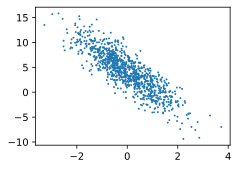

In [3]:
import torch 
from torch import nn
import random
from torch.utils import data
from d2l import torch as d2l

def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

print('features:', features[0],'\nlabel:', labels[0])

# 绘图，查看分布
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), 
                labels.detach().numpy(), 1);

In [4]:
# 1 读取数据
# def load_array(data_arrays, batch_size, is_train=True):  #@save
#     """构造一个PyTorch数据迭代器"""
#     dataset = data.TensorDataset(*data_arrays)
#     return data.DataLoader(dataset, batch_size, shuffle=is_train)

# batch_size = 10
# data_iter = load_array((features, labels), batch_size)

batch_size = 10
dataset = data.TensorDataset(*(features, labels)) # 将列表解开成几个独立的参数，传入函数。类似的运算符还有两个星号(**)，是将字典解开成独立的元素作为形参。
data_iter = data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

# 2 定义模型
net = nn.Sequential(nn.Linear(2, 1))
# 3 定义损失函数
loss_fn = nn.MSELoss()
# 4 定义优化算法
trainer = torch.optim.SGD(net.parameters(), lr=0.03)
# 5 训练模板
num_epochs = 5
net = net 
loss_fn = loss_fn 
trainer = trainer
for epoch in range(num_epochs):
    for X, y in data_iter:
        y_hat = net(X)                  # 计算预测值
        loss = loss_fn(y_hat ,y)        # 根据预测值和真实值计算损失
        trainer.zero_grad()             # pytorch不能自动进行清零，所以手动进行
        loss.backward()                 # 损失自动反向传播
        trainer.step()                  # 优化器自动跟新参数
    loss = loss_fn(net(features), labels)
    print(f'epoch {epoch + 1}, loss {loss:f}')

w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

epoch 1, loss 0.000243
epoch 2, loss 0.000103
epoch 3, loss 0.000102
epoch 4, loss 0.000103
epoch 5, loss 0.000103
w的估计误差： tensor([ 0.0003, -0.0007])
b的估计误差： tensor([0.0008])


### 2.1.2. <a id='toc2_1_2_'></a>[专题-损失函数](#toc0_)
#### 2.1.2.1. <a id='toc2_1_2_1_'></a>[均绝对值误差-l1 loss](#toc0_)

#### 2.1.2.2. <a id='toc2_1_2_2_'></a>[均方误差-l2 loss](#toc0_)

#### 2.1.2.3. <a id='toc2_1_2_3_'></a>[交叉熵](#toc0_)

#### 2.1.2.4. <a id='toc2_1_2_4_'></a>[自定义](#toc0_)

### 2.1.3. <a id='toc2_1_3_'></a>[专题-优化器](#toc0_)

#### 2.1.3.1. <a id='toc2_1_3_1_'></a>[梯度下降](#toc0_)

#### 2.1.3.2. <a id='toc2_1_3_2_'></a>[adagrad](#toc0_)

#### 2.1.3.3. <a id='toc2_1_3_3_'></a>[RMSProp](#toc0_)

## 2.2. <a id='toc2_2_'></a>[MLP](#toc0_)

## 2.3. <a id='toc2_3_'></a>[softmax](#toc0_)

In [11]:
import torch 
import torchvision 

train = torchvision.datasets.FashionMNIST(root="./Datas/Pytorch/FashionMNIST", 
                                  train= True, 
                                  download=True)
test = torchvision.datasets.FashionMNIST(root="./Datas/Pytorch/FashionMNIST", 
                                  train= False, 
                                  download=True)
len(trian), len(test)

Failed to download (trying next):
<urlopen error [Errno 11001] getaddrinfo failed>



RuntimeError: Error downloading train-images-idx3-ubyte.gz